In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install swig -y
!pip install Cython numpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (970 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [ ]:
!pip install auto-sklearn

Processing /root/.cache/pip/wheels/92/97/20/8edf157c4cfb9ac276d1d3291217e0e2cb73fec6766574674d/auto_sklearn-0.10.0-cp36-none-any.whl
Processing /root/.cache/pip/wheels/29/a6/af/9ec3c1ff517759ad1aad6babcbcf047dd5078c8b08fa4e63cc/smac-0.13.1-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ed/0f/4d7e42a9dfef3a1898e03cffa8f1cfcd1f96507d718808b2db584c6f8401/pyrfr-0.8.0.tar.gz
Processing /root/.cache/pip/wheels/a9/b0/b5/8c7e6810aee14bc4ed4a542ce56e744126263bf4f4825a9094/lazy_import-0.2.2-py2.py3-none-any.whl
  Created wheel for pyrfr: filename=pyrfr-0.8.0-cp36-cp36m-linux_x86_64.whl size=2540830 sha256=56504ca8cd5506c7330f56dc6100e0d13604f73c59936e9871e149b946379e8a
  Stored in directory: /root/.cache/pip/wheels/61/1a/d2/b5aee388a492a01946143d3c976b2ca810af537480e1f16999
Successfully built pyrfr


# Airbnb Prices Prediction


Данные для Рима. Взяла calendar и listing, а reviews оставила, т. к. использовала только общее количество отзывов.

## Обработка данных

Прочитаем CSV

In [ ]:
#index_col не работает из-за nan, пришлось отдельно делать - не понимаю почему, в listings тоже не без nan, но там при прочтении csv можно задавать индекс
calendar = pd.read_csv('/content/drive/My Drive/colab/airbnb/calendar.csv')
calendar = calendar.dropna()
#потом буду делать фичерс инжиниринг из двух датафреймов, нужно будет совмещать по id, поэтому лучше сейчас указать индекс
calendar.set_index('listing_id')
print(calendar.shape)
calendar.head()

(10289706, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,50471,2020-09-16,f,$59.00,$59.00,1.0,1125.0
1,50471,2020-09-17,f,$59.00,$59.00,1.0,1125.0
2,50471,2020-09-18,f,$90.00,$90.00,1.0,1125.0
3,50471,2020-09-19,f,$90.00,$90.00,1.0,1125.0
4,50471,2020-09-20,f,$63.00,$63.00,1.0,1125.0


In [ ]:
listings = pd.read_csv('/content/drive/My Drive/colab/airbnb/listings.csv', index_col='id')
#ещё нужно будет сделать график для первых самых популярных листингов, отсортируем по 'number_of_reviews'
listings = listings.sort_values(by='number_of_reviews', ascending=False)
print(listings.shape)
listings.head()

(28191, 73)


,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2399029,https://www.airbnb.com/rooms/2399029,20200913192525,2020-09-14,B&B Rione Monti,"Welcoming 2 double bedrooms, in Monti, Rome's ...","the first and oldest district in Rome, with ty...",https://a0.muscache.com/pictures/33246500/cf6a...,12258559,https://www.airbnb.com/users/show/12258559,Marisa,2014-02-15,"Rome, Lazio, Italy",solare e accogliente \n,within an hour,100%,100%,t,https://a0.muscache.com/im/users/12258559/prof...,https://a0.muscache.com/im/users/12258559/prof...,Monti,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.89426,12.49024,Private room in apartment,Private room,2,NaN,1 private bath,1.0,2.0,"[""TV"", ""Private entrance"", ""Essentials"", ""Lapt...",$40.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,25,44,74,310,2020-09-14,741,70,9,2014-04-06,2020-09-08,93.0,9.0,10.0,10.0,10.0,10.0,9.0,NaN,t,2,0,2,0,9.44
2709785,https://www.airbnb.com/rooms/2709785,20200913192525,2020-09-14,B&B Rione Monti,"Welcoming 2 double bedrooms, in Monti, Rome's ...","The Monti district included the Esquiline, Vim...",https://a0.muscache.com/pictures/35382125/e323...,12258559,https://www.airbnb.com/users/show/12258559,Marisa,2014-02-15,"Rome, Lazio, Italy",solare e accogliente \n,within an hour,100%,100%,t,https://a0.muscache.com/im/users/12258559/prof...,https://a0.muscache.com/im/users/12258559/prof...,Monti,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.89436,12.49025,Private room in apartment,Private room,2,NaN,2 baths,1.0,0.0,"[""TV"", ""Free street parking"", ""Shower gel"", ""H...",$35.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,27,53,83,338,2020-09-14,682,69,6,2014-04-15,2020-09-07,94.0,10.0,9.0,10.0,10.0,10.0,10.0,NaN,t,2,0,2,0,8.72
825299,https://www.airbnb.com/rooms/825299,20200913192525,2020-09-14,Pettinarihome 2 Campo dei Fiori,<b>The space</b><br />This just under 600 sq f...,NaN,https://a0.muscache.com/pictures/14143884/a9c5...,3925580,https://www.airbnb.com/users/show/3925580,Rita,2012-10-20,"Rome, Lazio, Italy","Mi piace la buona cucina,la natura, leggere de...",within an hour,100%,99%,t,https://a0.muscache.com/im/users/3925580/profi...,https://a0.muscache.com/im/users/3925580/profi...,Regola,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,I Centro Storico,NaN,41.89553,12.47368,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""TV"", ""Washer"", ""Shower gel"", ""Baking sheet"",...",$60.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,24,54,84,359,2020-09-14,661,44,4,2013-02-18,2020-09-13,98.0,10.0,10.0,10.0,10.0,10.0,10.

Таргет - `calendar['price']`

In [ ]:
calendar_ = calendar.copy() 

Преобразуем колонки цен в численные, дату в тип datetime, в колонке available заменим t на 1 и f на 0

In [ ]:
calendar_['price'] = calendar_['price'].str.replace('$', '').str.replace(',', '')
calendar_['price'] = calendar_['price'].astype(float)

In [ ]:
calendar_['adjusted_price'] = calendar_['adjusted_price'].str.replace('$', '').str.replace(',', '')
calendar_['adjusted_price'] = calendar_['adjusted_price'].astype(float)

In [ ]:
calendar_.date = pd.to_datetime(calendar_.date)

In [ ]:
calendar_['available'].replace('f', 0, inplace=True)
calendar_['available'].replace('t', 1, inplace=True)

Заменим лучше dt на int месяцы, так проще, чем с dt работать (и AutoML как раз не хочет принимать dt формат)

In [ ]:
calendar_['date'] = calendar_['date'].dt.month

Теперь везде численные данные

In [ ]:
calendar_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10289706 entries, 0 to 10291083
Data columns (total 7 columns):
listing_id        int64
date              int64
available         int64
price             float64
adjusted_price    float64
minimum_nights    float64
maximum_nights    float64
dtypes: float64(4), int64(3)
memory usage: 628.0 MB


Проделаем то же самое с listings

In [ ]:
listings_ = listings.copy()

In [ ]:
listings_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28191 entries, 2399029 to 45418599
Data columns (total 73 columns):
listing_url                                     28191 non-null object
scrape_id                                       28191 non-null int64
last_scraped                                    28191 non-null object
name                                            28183 non-null object
description                                     27714 non-null object
neighborhood_overview                           18500 non-null object
picture_url                                     28190 non-null object
host_id                                         28191 non-null int64
host_url                                        28191 non-null object
host_name                                       28185 non-null object
host_since                                      28185 non-null object
host_location                                   28138 non-null object
host_about                                  

'calendar_updated', 'bathrooms', 'neighbourhood_group_cleansed', 'license' - полностью нулевые, нужно от них избавиться. Ещё нам точно не нужны 'listing_url', 'scrape_id', 'host_id'

In [ ]:
listings_ = listings_.drop(['listing_url', 'calendar_updated', 'bathrooms', 'neighbourhood_group_cleansed', 'license', 'scrape_id', 'host_id'], axis=1)

In [ ]:
listings_ = listings_.dropna(axis=0)

In [ ]:
listings_['price'] = listings_['price'].str.replace('$', '').str.replace(',', '')
listings_['price'] = listings_['price'].astype(float)

In [ ]:
listings_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5843 entries, 2399029 to 42382895
Data columns (total 66 columns):
last_scraped                                    5843 non-null object
name                                            5843 non-null object
description                                     5843 non-null object
neighborhood_overview                           5843 non-null object
picture_url                                     5843 non-null object
host_url                                        5843 non-null object
host_name                                       5843 non-null object
host_since                                      5843 non-null object
host_location                                   5843 non-null object
host_about                                      5843 non-null object
host_response_time                              5843 non-null object
host_response_rate                              5843 non-null object
host_acceptance_rate                            5843 no

## EDA

Распределение целевой переменной (похоже на гамма-распределение)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


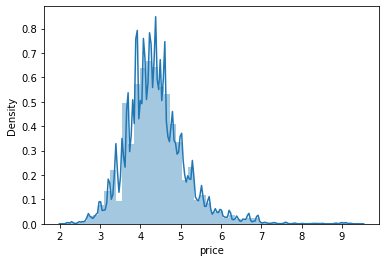

In [ ]:
sns.distplot(np.log(calendar_['price']))

В какие месяцы квартиры наиболее дорогие:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


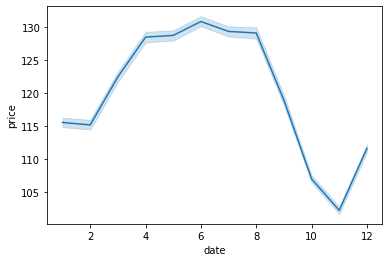

In [ ]:
sns.lineplot(calendar_['date'], calendar_['price'])

Как связаны количество отзывов и цена?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


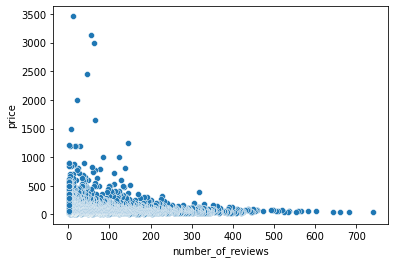

In [ ]:
sns.scatterplot(listings_['number_of_reviews'], listings_['price'])

## Отбор признаков

In [ ]:
# убираем минус
corrs = abs(listings_.corr())

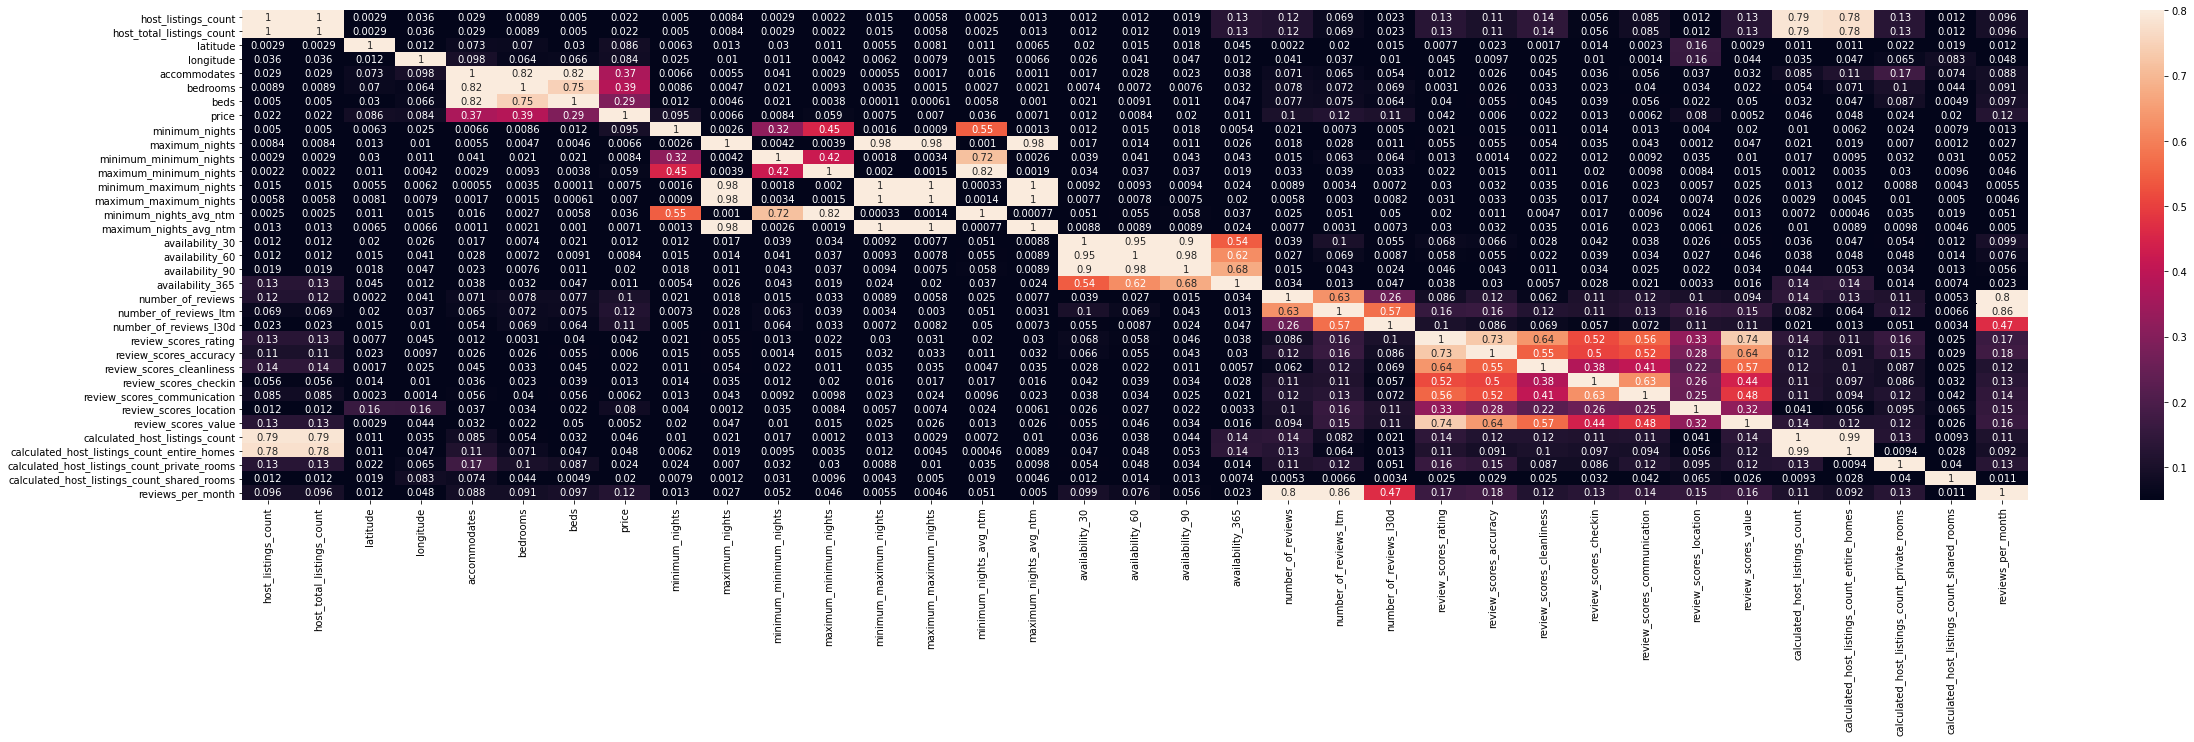

In [ ]:
f, ax = plt.subplots(figsize=(40, 9))
sns.heatmap(corrs, vmax=0.8, vmin=0.05, annot=True)

In [ ]:
#Какие функции скоррелированы с таргетом
corr_target = abs(corrs['price'])
relevant_features = corr_target[corr_target>0.005]
#Составляем список из значимых признаков
rels = [i for i in relevant_features.index]
#Cкладываем нужные колонки в df
df = pd.DataFrame(data=listings_, columns=rels)

Осталось 35 признаков

In [ ]:
print(df.shape)
df.head()

(5843, 35)


,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2399029,2.0,2.0,41.89426,12.49024,2,1.0,2.0,40.00,1,1125,1,1,1125,1125,1.0,1125.0,25,44,74,310,741,70,9,93.0,9.0,10.0,10.0,10.0,10.0,9.0,2,0,2,0,9.44
2709785,2.0,2.0,41.89436,12.49025,2,1.0,0.0,35.00,1,1125,1,1,1125,1125,1.0,1125.0,27,53,83,338,682,69,6,94.0,10.0,9.0,10.0,10.0,10.0,10.0,2,0,2,0,8.72
1385250,4.0,4.0,41.88985,12.47346,2,1.0,1.0,37.14,2,60,2,2,1125,1125,2.0,1125.0,10,30,60,331,661,62,5,95.0,10.0,9.0,10.0,10.0,10.0,9.0,5,5,0,0,7.64
1373696,4.0,4.0,41.88837,12.47453,5,2.0,2.0,41.00,2,30,2,2,1125,1125,2.0,1125.0,7,30,60,335,643,61,3,98.0,10.0,10.0,10.0,10.0,10.0,10.0,5,5,0,0,7.41
1420888,10.0,10.0,41.89267,12.47423,4,2.0,2.0,60.29,1,365,1,1,365,365,1.0,365.0,28,58,88,361,603,60,2,87.0,9.0,9.0,10.0,10.0,10.0,9.0,9,9,0,0,7.02


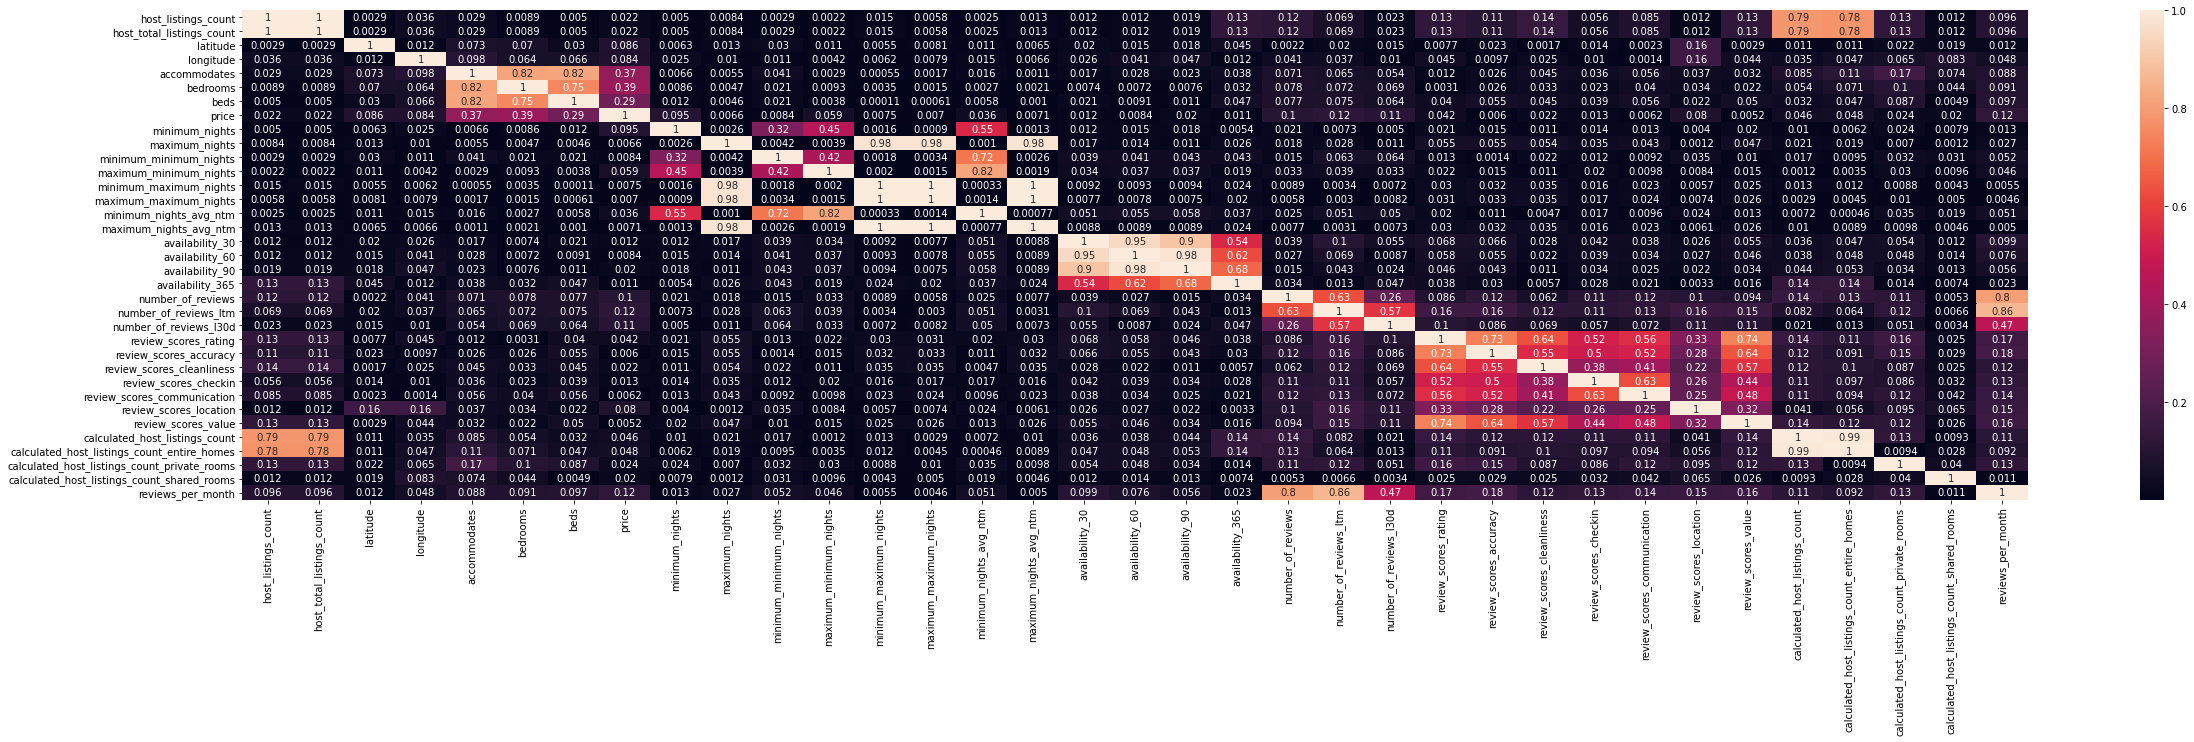

In [ ]:
f, ax = plt.subplots(figsize=(40, 9))
sns.heatmap(abs(df.corr()), annot=True)

В общем кроме как для графиков я не использовала calendar. Не поняла даже зачем он был нужен - все его колонки есть в listings. 

## Линейная модель

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet, LassoCV 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet, LassoCV 

In [ ]:
# Отделяем таргет
X = df.drop(columns='price')
y = pd.DataFrame(df['price'])
# Разбиваем на train и test сеты (80% на трейн, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Тренировочные признаки: ', X_train.shape, 'Тренировочные таргеты: ', y_train.shape, 'Тестовые признаки: ', X_test.shape, 'Тестовые таргеты: ', y_test.shape)

Тренировочные признаки:  (4674, 34) Тренировочные таргеты:  (4674, 1) Тестовые признаки:  (1169, 34) Тестовые таргеты:  (1169, 1)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Пересечение: ', lr.intercept_)
names = []
for j in lr.coef_:
  for k in j:
    names.append(np.round(k, 2))
coefs = {x:y for x,y in zip(X_train.columns, names)}
print(coefs)
print(f'Качество при обучении {lr.score(X_train, y_train).round(2)}, качество на отложенной выборке {lr.score(X_test, y_test).round(2)}')

Пересечение:  [-12087.92399458]
{'host_listings_count': 0.02, 'host_total_listings_count': 0.02, 'latitude': 331.56, 'longitude': -160.89, 'accommodates': 12.59, 'bedrooms': 33.79, 'beds': -7.26, 'minimum_nights': 1.35, 'maximum_nights': 0.0, 'minimum_minimum_nights': -0.1, 'maximum_minimum_nights': 0.29, 'minimum_maximum_nights': 0.0, 'maximum_maximum_nights': -0.01, 'minimum_nights_avg_ntm': -1.48, 'maximum_nights_avg_ntm': 0.01, 'availability_30': 0.35, 'availability_60': 1.23, 'availability_90': -1.08, 'availability_365': 0.03, 'number_of_reviews': -0.03, 'number_of_reviews_ltm': -0.42, 'number_of_reviews_l30d': -5.1, 'review_scores_rating': 1.91, 'review_scores_accuracy': -6.04, 'review_scores_cleanliness': 4.46, 'review_scores_checkin': 1.58, 'review_scores_communication': -3.11, 'review_scores_location': 15.92, 'review_scores_value': -8.47, 'calculated_host_listings_count': 3.66, 'calculated_host_listings_count_entire_homes': -3.67, 'calculated_host_listings_count_private_rooms'

In [ ]:
lass = Lasso(alpha = 0.01)
lass.fit(X_train, y_train)
print('Пересечение: ', lass.intercept_)
names = []
for j in lass.coef_:
  names.append(np.round(j, 2))
coefs = {x:y for x,y in zip(X_train.columns, names)}
print(coefs)
print(f'Качество при обучении {lass.score(X_train, y_train).round(2)}, качество на отложенной выборке {lass.score(X_test, y_test).round(2)}')

Пересечение:  [-10732.9807683]
{'host_listings_count': 0.04, 'host_total_listings_count': 0.0, 'latitude': 294.46, 'longitude': -145.06, 'accommodates': 12.63, 'bedrooms': 33.76, 'beds': -7.26, 'minimum_nights': 1.35, 'maximum_nights': 0.0, 'minimum_minimum_nights': -0.09, 'maximum_minimum_nights': 0.3, 'minimum_maximum_nights': 0.0, 'maximum_maximum_nights': -0.01, 'minimum_nights_avg_ntm': -1.48, 'maximum_nights_avg_ntm': 0.01, 'availability_30': 0.36, 'availability_60': 1.22, 'availability_90': -1.08, 'availability_365': 0.03, 'number_of_reviews': -0.03, 'number_of_reviews_ltm': -0.42, 'number_of_reviews_l30d': -5.09, 'review_scores_rating': 1.9, 'review_scores_accuracy': -6.06, 'review_scores_cleanliness': 4.44, 'review_scores_checkin': 1.39, 'review_scores_communication': -3.01, 'review_scores_location': 16.23, 'review_scores_value': -8.41, 'calculated_host_listings_count': 3.63, 'calculated_host_listings_count_entire_homes': -3.65, 'calculated_host_listings_count_private_rooms': 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25047540.4132505, tolerance: 7002.016590391213
  positive)


In [ ]:
el = ElasticNet(alpha = 0.01, l1_ratio = 0.9)
el.fit(X_train, y_train)
print('Пересечение: ', el.intercept_)
names = []
for j in el.coef_:
  names.append(np.round(j, 2))
coefs = {x:y for x,y in zip(X_train.columns, names)}
print(coefs)
print(f'Качество при обучении {el.score(X_train, y_train).round(2)}, качество на отложенной выборке {el.score(X_test, y_test).round(2)}')

Пересечение:  [-2157.17586239]
{'host_listings_count': 0.04, 'host_total_listings_count': 0.0, 'latitude': 63.02, 'longitude': -56.46, 'accommodates': 12.93, 'bedrooms': 33.67, 'beds': -7.39, 'minimum_nights': 1.34, 'maximum_nights': 0.0, 'minimum_minimum_nights': -0.08, 'maximum_minimum_nights': 0.31, 'minimum_maximum_nights': 0.0, 'maximum_maximum_nights': -0.01, 'minimum_nights_avg_ntm': -1.52, 'maximum_nights_avg_ntm': 0.01, 'availability_30': 0.42, 'availability_60': 1.19, 'availability_90': -1.08, 'availability_365': 0.04, 'number_of_reviews': -0.03, 'number_of_reviews_ltm': -0.43, 'number_of_reviews_l30d': -5.06, 'review_scores_rating': 1.91, 'review_scores_accuracy': -6.51, 'review_scores_cleanliness': 4.52, 'review_scores_checkin': 0.92, 'review_scores_communication': -2.97, 'review_scores_location': 18.28, 'review_scores_value': -8.32, 'calculated_host_listings_count': 3.7, 'calculated_host_listings_count_entire_homes': -3.73, 'calculated_host_listings_count_private_rooms': -

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25300369.889431287, tolerance: 7002.016590391213
  positive)


In [ ]:
rdg = Ridge(alpha = 1)
rdg.fit(X_train, y_train)
print('Пересечение: ', rdg.intercept_)
names = []
for j in rdg.coef_:
  for k in j:
    names.append(np.round(k, 2))
coefs = {x:y for x,y in zip(X_train.columns, names)}
print(coefs)
print(f'Качество при обучении {rdg.score(X_train, y_train).round(2)}, качество на отложенной выборке {rdg.score(X_test, y_test).round(2)}')

Пересечение:  [-6485.37467749]
{'host_listings_count': 0.02, 'host_total_listings_count': 0.02, 'latitude': 185.06, 'longitude': -118.69, 'accommodates': 12.76, 'bedrooms': 33.8, 'beds': -7.35, 'minimum_nights': 1.35, 'maximum_nights': 0.0, 'minimum_minimum_nights': -0.09, 'maximum_minimum_nights': 0.3, 'minimum_maximum_nights': 0.0, 'maximum_maximum_nights': -0.01, 'minimum_nights_avg_ntm': -1.5, 'maximum_nights_avg_ntm': 0.01, 'availability_30': 0.38, 'availability_60': 1.2, 'availability_90': -1.08, 'availability_365': 0.03, 'number_of_reviews': -0.03, 'number_of_reviews_ltm': -0.42, 'number_of_reviews_l30d': -5.09, 'review_scores_rating': 1.91, 'review_scores_accuracy': -6.31, 'review_scores_cleanliness': 4.52, 'review_scores_checkin': 1.31, 'review_scores_communication': -3.07, 'review_scores_location': 17.13, 'review_scores_value': -8.44, 'calculated_host_listings_count': 3.71, 'calculated_host_listings_count_entire_homes': -3.73, 'calculated_host_listings_count_private_rooms': -

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lass_scaled = Lasso(alpha=0.1)
lass_scaled.fit(X_train_scaled,y_train)
names = []
for j in lass_scaled.coef_:
  names.append(np.round(j, 2))
coefs = {x:y for x,y in zip(X_train.columns, names)}
print(coefs)
print('Пересечение: ', lass_scaled.intercept_)
print(f'Качество при обучении {lass_scaled.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {lass_scaled.score(X_test_scaled, y_test).round(2)}')

{'host_listings_count': 1.59, 'host_total_listings_count': 0.0, 'latitude': 5.7, 'longitude': -4.22, 'accommodates': 28.54, 'bedrooms': 30.8, 'beds': -11.85, 'minimum_nights': 18.34, 'maximum_nights': 0.54, 'minimum_minimum_nights': -0.75, 'maximum_minimum_nights': 2.36, 'minimum_maximum_nights': 2.06, 'maximum_maximum_nights': -2.49, 'minimum_nights_avg_ntm': -8.38, 'maximum_nights_avg_ntm': 0.0, 'availability_30': 6.99, 'availability_60': 16.92, 'availability_90': -27.32, 'availability_365': 3.3, 'number_of_reviews': -2.31, 'number_of_reviews_ltm': -5.52, 'number_of_reviews_l30d': -6.6, 'review_scores_rating': 10.43, 'review_scores_accuracy': -3.68, 'review_scores_cleanliness': 3.08, 'review_scores_checkin': 0.66, 'review_scores_communication': -1.53, 'review_scores_location': 8.67, 'review_scores_value': -5.53, 'calculated_host_listings_count': 32.12, 'calculated_host_listings_count_entire_homes': -32.53, 'calculated_host_listings_count_private_rooms': 0.0, 'calculated_host_listings

In [ ]:
model = ElasticNet(alpha=0.1, l1_ratio = 0.9)
model.fit(X_train_scaled, y_train)
y_model_pred = model.predict(X_test)
print(f'Качество при обучении {model.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {model.score(X_test_scaled, y_test).round(2)}')

Качество при обучении 0.21, качество на отложенной выборке 0.15


В общем я плохо поработала с данными и скор плохой

## AutoML

In [ ]:
import autosklearn
from autosklearn.regression import AutoSklearnRegressor

In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_example_tmp',
    output_folder='/tmp/autosklearn_regression_example_out',
)
automl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(dask_client=None,
                     delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initia...
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None, ml_memory_limit=3072,
                     n_jobs=None,
                     output_folder='/tmp/autosklearn_regression_example_out',
                     per_run_time_limit=30, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     smac_scenario_args=None, time_left_for_this_tas

??? Не очень понятно!

In [ ]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.01, 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 1.0, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:random_forest:min_samples_split': 2, 'regressor:random_forest:min_